# Classifying with Clusterless Spikes
## Set Plotting Defaults

In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

STATE_COLORS = {
    'stationary': '#9f043a',
    'fragmented': '#ff6944',
    'continuous': '#521b65',
    'stationary-continuous-mix': '#61c5e6',
    'fragmented-continuous-mix': '#2a586a',
    '': '#c7c7c7',
}

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'text.color': '#222222',
    }
sns.set(style="white", context='paper', rc=rc_params,
        font_scale=1.3)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Simulate Clusterless Data

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(0.0, 349.999)

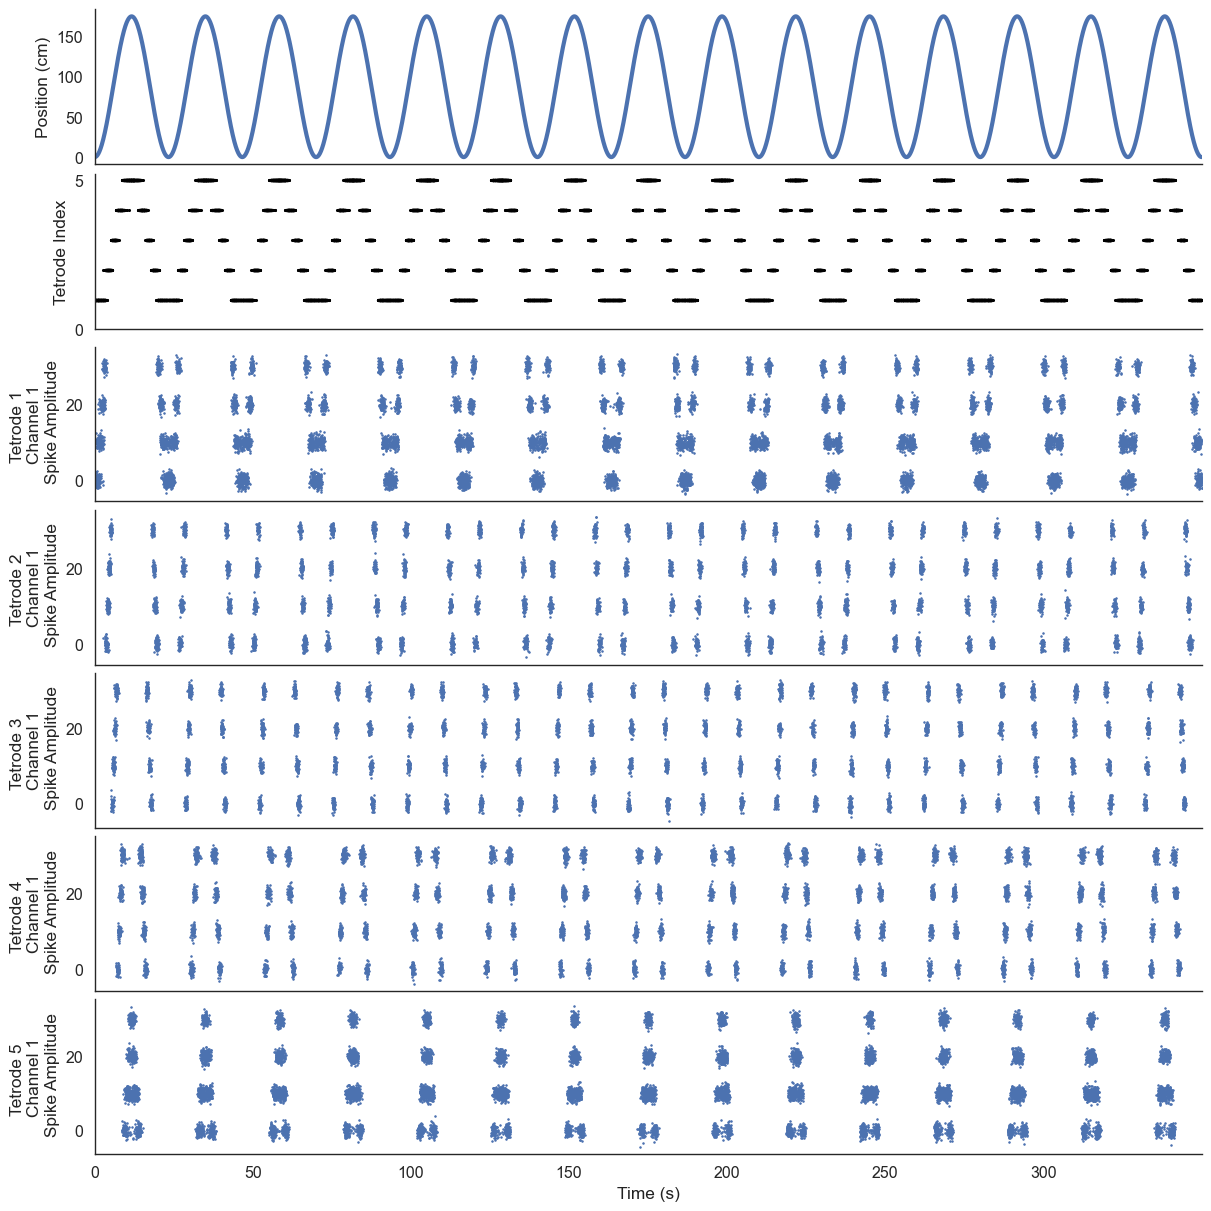

In [2]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, linear_distance, sampling_frequency,
 multiunits, multiunits_spikes) = make_simulated_run_data()

spike_ind, neuron_ind = np.nonzero(multiunits_spikes)

fig, axes = plt.subplots(7, 1, figsize=(12, 12), constrained_layout=True, sharex=True)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel('Position (cm)')

axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_yticks((0, multiunits_spikes.shape[1]))
axes[1].set_ylabel('Tetrode Index')

for tetrode_ind in range(multiunits.shape[-1]):
    axes[2 + tetrode_ind].scatter(time, multiunits[:, 0, tetrode_ind], s=1)
    axes[2 + tetrode_ind].set_ylabel(f'Tetrode {tetrode_ind + 1} \n Channel 1 \n Spike Amplitude')

sns.despine()
axes[-1].set_xlabel('Time (s)')
axes[-1].set_xlim((time.min(), time.max()))

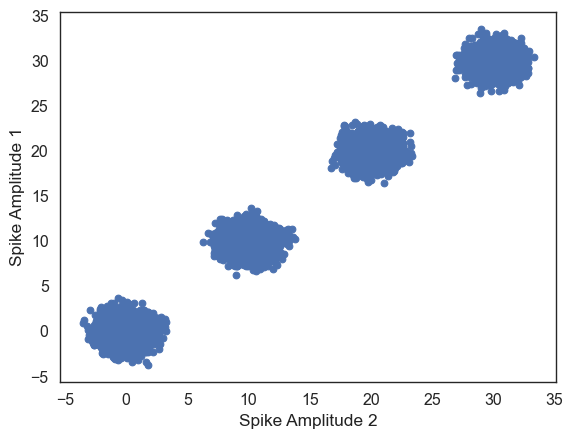

In [3]:
plt.scatter(multiunits[:, 0, 0], multiunits[:, 1, 0])
plt.ylabel('Spike Amplitude 1')
plt.xlabel('Spike Amplitude 2');

## Fit Clusterless Classifier

In [4]:
from replay_trajectory_classification import (
    ClusterlessClassifier, Environment,
    RandomWalk, Uniform, Identity, estimate_movement_var)

movement_var = estimate_movement_var(linear_distance, sampling_frequency)


# If your marks are integers, use this algorithm because it is much faster
clusterless_algorithm = 'multiunit_likelihood'
clusterless_algorithm_params = {
    'mark_std': 1.0,
    'position_std': 12.5,
}

environment = Environment(place_bin_size=np.sqrt(movement_var))

continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]


classifier = ClusterlessClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params)
classifier.fit(linear_distance, multiunits)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


,environments,"(Environment(e...t_threshold=0),)"
,observation_models,"(ObservationMo...oding_group=0), ...)"
,continuous_transition_types,"[[RandomWalk(en...ffusion=False), Uniform(envir...nt2_name=None), ...], [Uniform(envir...nt2_name=None), Uniform(envir...nt2_name=None), ...], ...]"
,discrete_transition_type,DiagonalDiscr...al_value=0.98)
,initial_conditions_type,UniformInitialConditions()
,infer_track_interior,True
,clusterless_algorithm,'multiunit_likelihood'
,clusterless_algorithm_params,"{'mark_std': 1.0, 'position_std': 12.5}"


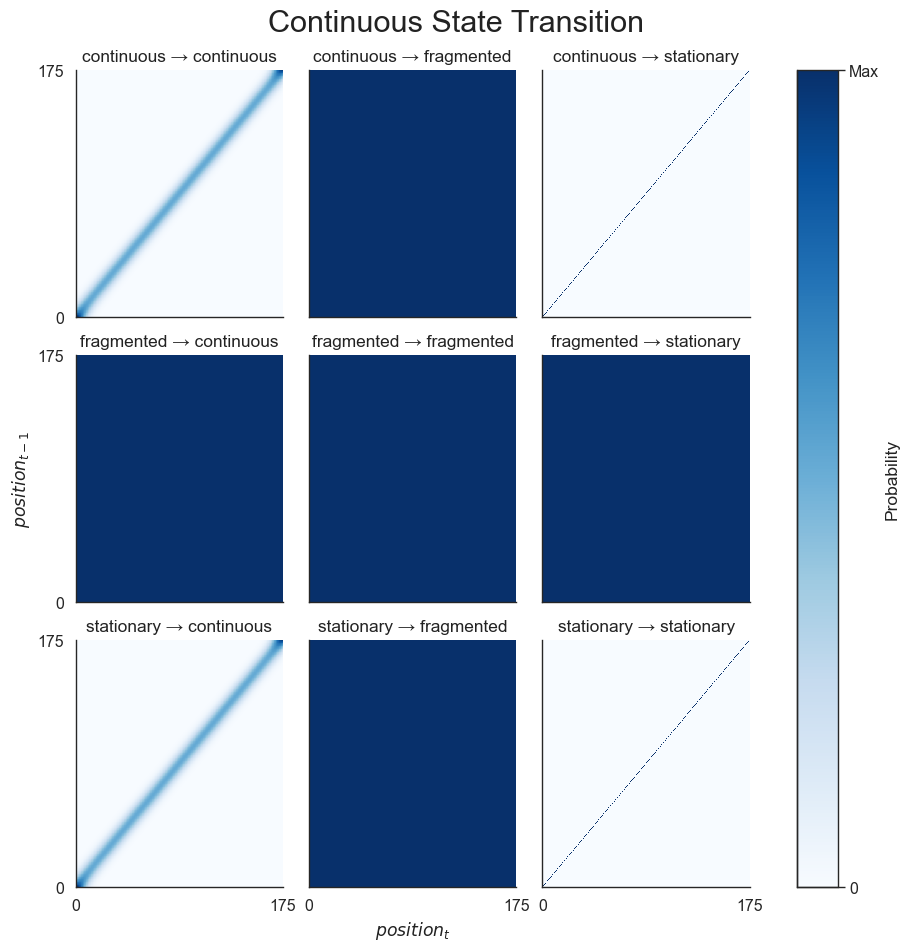

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(environment.place_bin_edges_, environment.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'stationary']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        # axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
        #                 va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))

plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel(r'$position_{t-1}$')
axes[-1, 1].set_xlabel(r'$position_{t}$')
plt.suptitle('Continuous State Transition', y=1.04, fontsize=22)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

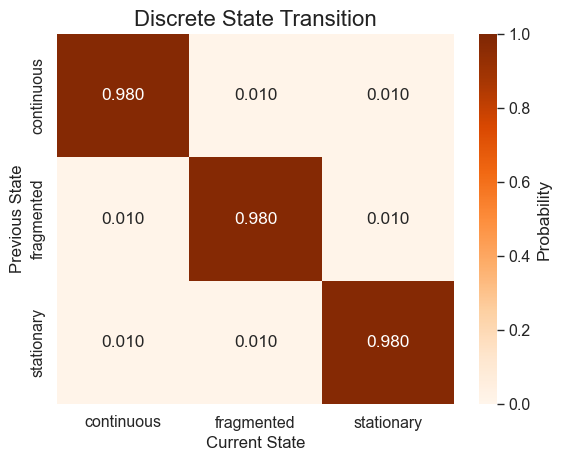

In [6]:
state_names = ['continuous', 'fragmented', 'stationary']
classifier.plot_discrete_state_transition(state_names)

## Test classifier on different replay types

In [7]:
def plot_classification(replay_time, test_multiunits, results):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
    test_multiunit_spikes = np.any(~np.isnan(test_multiunits), axis=1)
    spike_time_ind, neuron_ind = np.nonzero(test_multiunit_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black')
    axes[0].set_yticks((0, test_multiunit_spikes.shape[1]))
    axes[0].set_ylabel('Tetrode Index')

    replay_probabilities = results.acausal_posterior.sum('position')
    for state, probability in replay_probabilities.groupby('state'):
        probability.plot(x='time', color=STATE_COLORS[state], linewidth=3,
                         ax=axes[1], label=state)
    axes[1].set_title('')
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim((0.0, 1.05))
    axes[1].legend()

    results.acausal_posterior.sum('state').plot(
            x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    plt.xlim((replay_time.min(), replay_time.max()))
    sns.despine()

### Continuous

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/core.py:210: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


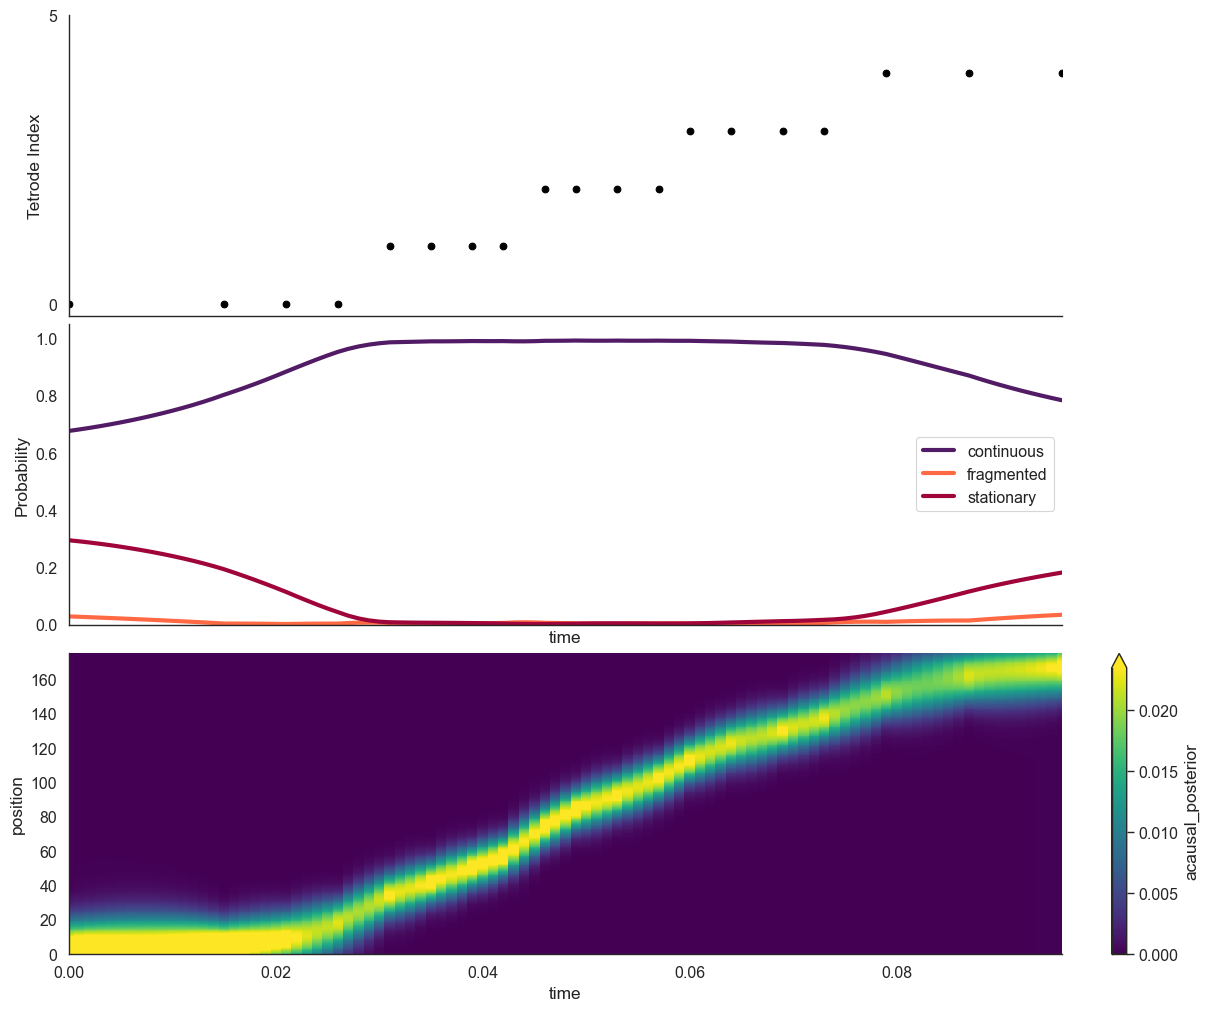

In [8]:
from replay_trajectory_classification.clusterless_simulation import make_continuous_replay

replay_time, test_multiunits = make_continuous_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

### Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


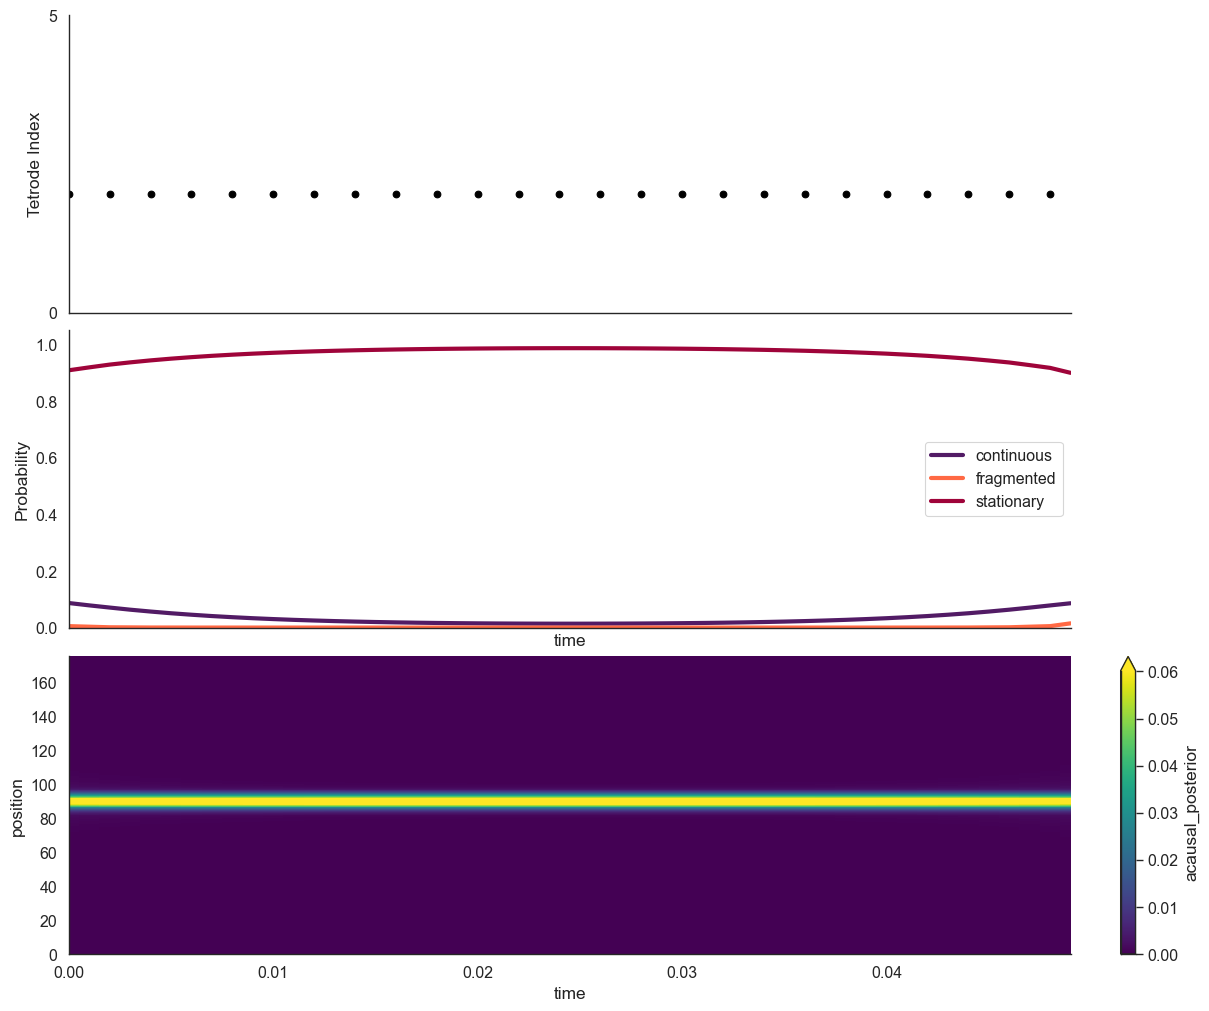

In [9]:
from replay_trajectory_classification.clusterless_simulation import make_hover_replay

replay_time, test_multiunits = make_hover_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

### Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


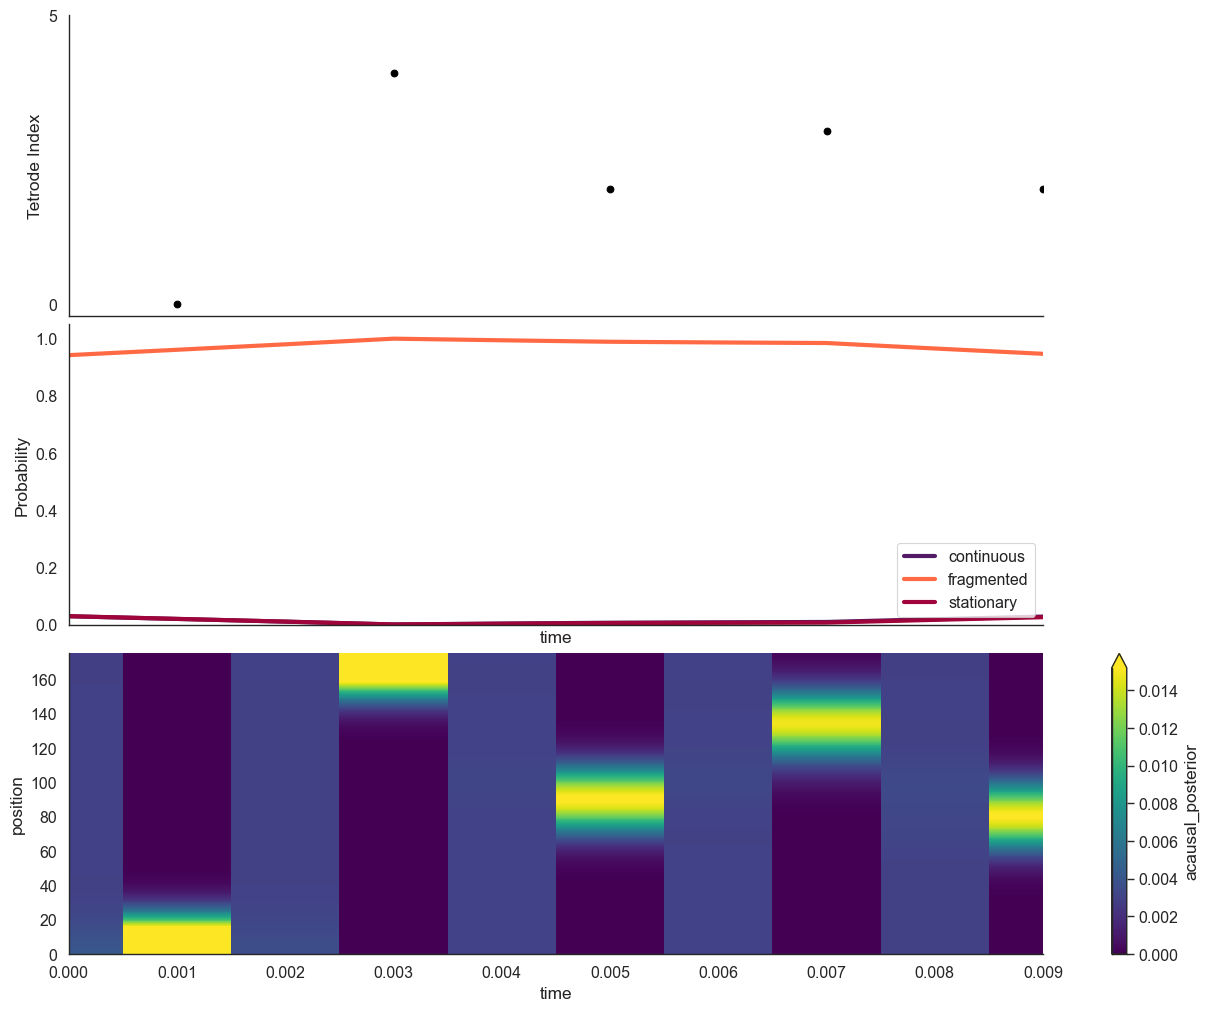

In [10]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_replay

replay_time, test_multiunits = make_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

### Stationary-Continuous-Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


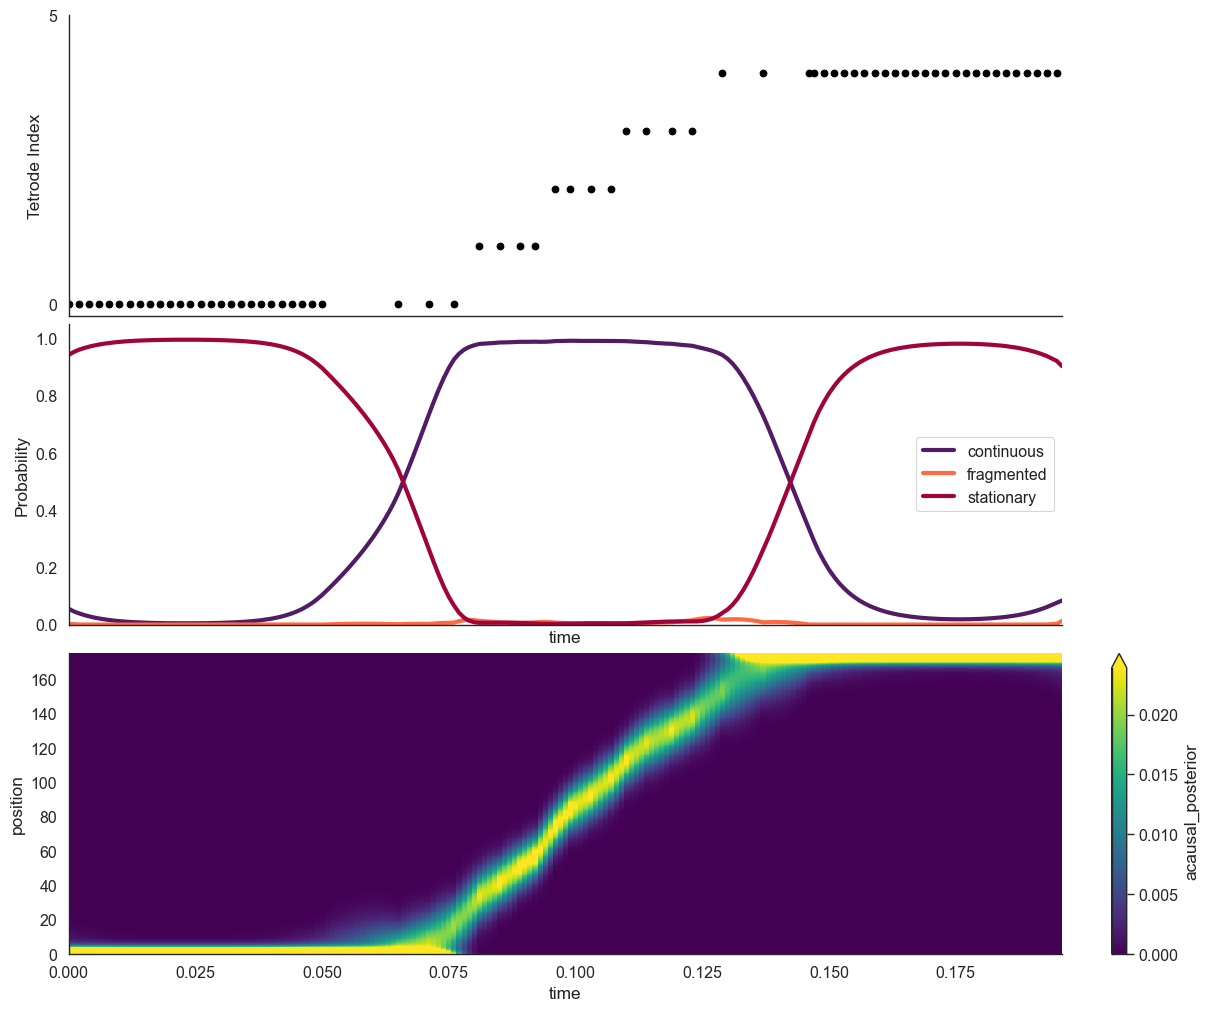

In [11]:
from replay_trajectory_classification.clusterless_simulation import make_hover_continuous_hover_replay

replay_time, test_multiunits = make_hover_continuous_hover_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

### Fragmented-Hover-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


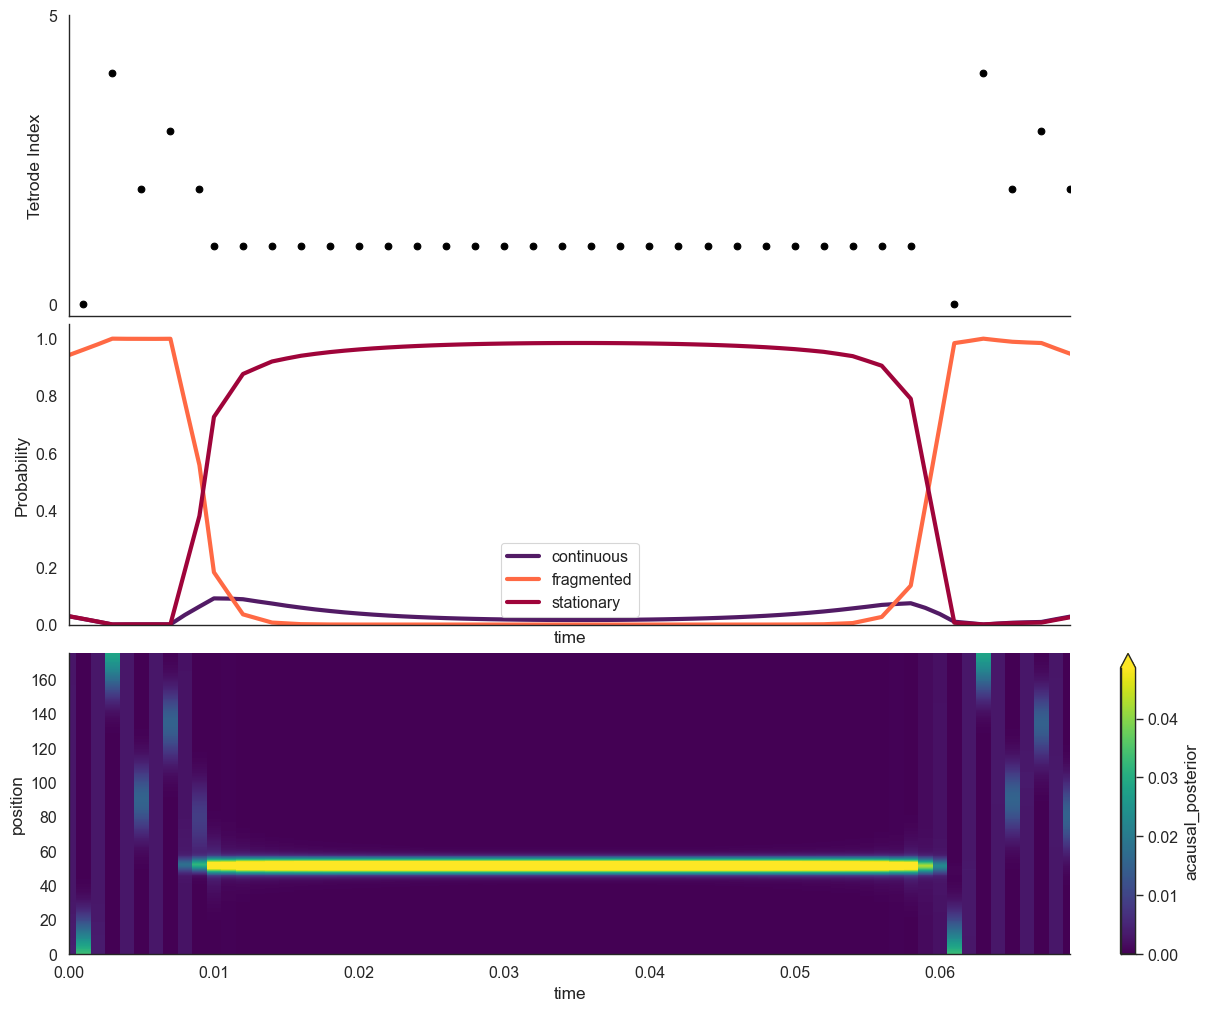

In [12]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_multiunits = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)

### Fragmented-Continuous-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/edeno/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(mean_rate) + np.log(density) - np.log(occupancy)
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


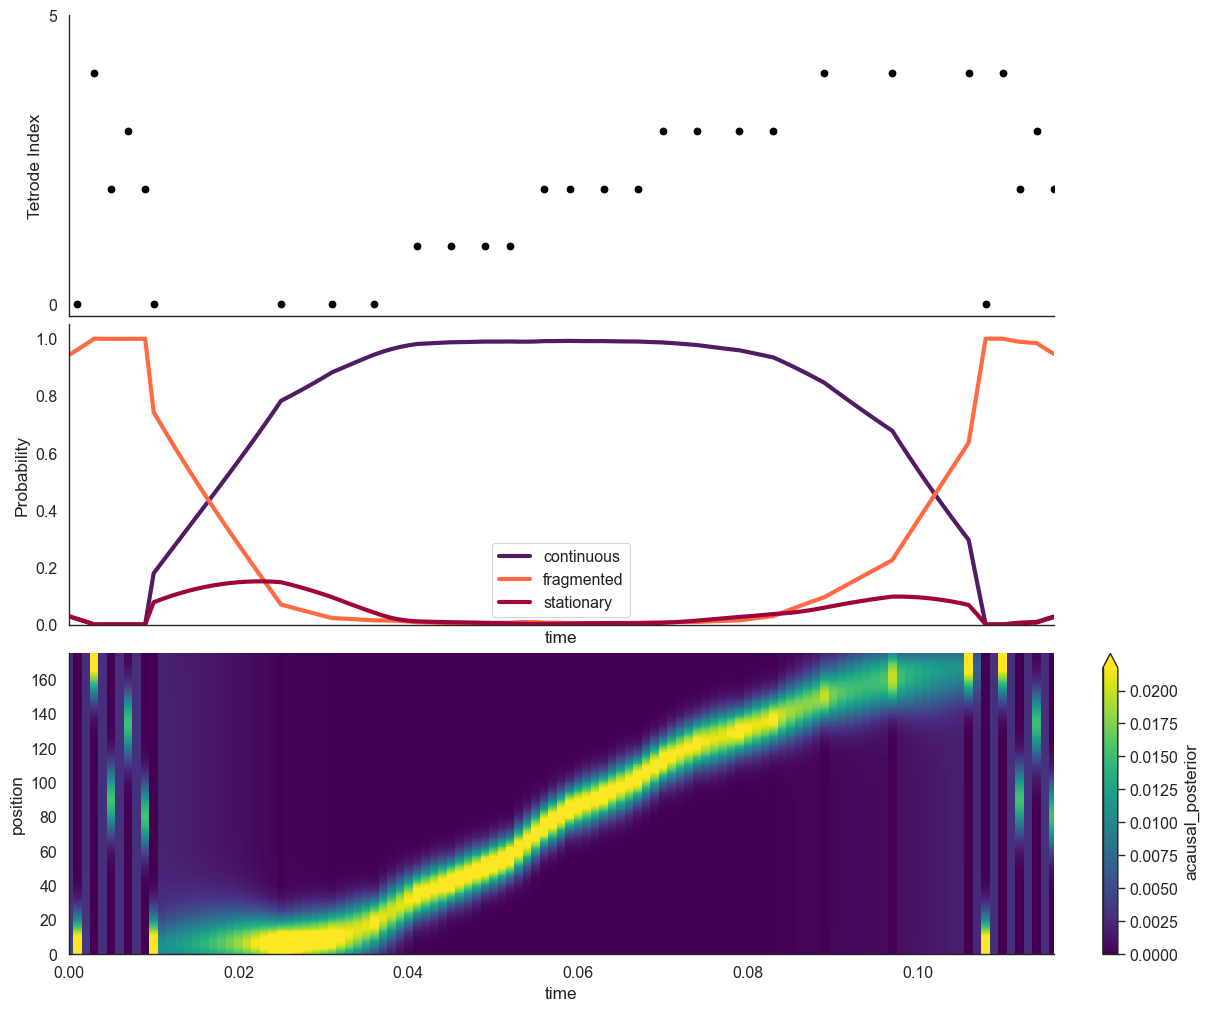

In [13]:
from replay_trajectory_classification.clusterless_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_multiunits = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_multiunits, results)